<a href="https://colab.research.google.com/github/NataliaBlueCloud/latency-confidence-intervals-estimator/blob/main/delay_percentiles_CI_mm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
system('git clone https://github.com/NataliaBlueCloud/latency-confidence-intervals-estimator.git')


In [75]:
system('sudo apt install libcairo2-dev')
install.packages('hrbrthemes')
library(hrbrthemes)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [1]:
install.packages("boot")
install.packages("igraph")
install.packages("simmer")
install.packages("SciViews")
install.packages("cowplot")
install.packages("zoo")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ellipse’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(boot)
library(igraph)
library(simmer)
library(SciViews)
library(ggplot2)
library(cowplot)
library(zoo)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [11]:
source("general_function_base.R")
source("simmer_function_base.R")

#Input data

In [7]:
Capacity_Gbps <- 10
PS_size = c(31.5, 95.5, 191.5, 383.5, 767.5, 1268.5, 1514, 5307.5)
PS_weights = c(0, 33.2,5.4, 3.3, 3.7, 34.6, 14.6, 5.2)/100
alpha = 0.01 #confidence error level
packets_number = 15000 #number of simulated packets for "simmer" execution time:  (traffic_ps/time_of_execution)


#MM1

##Simulation

In [8]:
mm1_simulation <- function(PS_size, PS_weights, Capacity_Gbps, Loads, packets_number = 1000){
  #################igrqph
  N = sum(PS_size*PS_weights)
  Traffic <- Loads*Capacity_Gbps*10^10/(8*N)
  g <- make_graph(edges = c(1,2), n=2, directed = FALSE)
  E(g)$Traffic <- Traffic
  E(g)$Load <- Loads
  E(g)$Capacity_ps <- Capacity_Gbps*10^10/(8*N)
  E(g)$Ni <- E(g)$Load/(1-E(g)$Load) # average number of packets in each system
  E(g)$Queue_Delay <- 1/(E(g)$Capacity_ps*(1-E(g)$Load))
  plot(g)

  ##################simmer
  lambda_simmer <- Traffic
  set.seed(123)
  env <- simmer("SuperDuperSim") #creating the simmer environment
  env %>% add_resource("node_1")
  #################creating cross trajectories with theirs generator

  traffic_1_2_<- trajectory() %>%
    seize("node_1") %>%
    timeout(function() rexp(1, E(g)[1]$Capacity_ps)) %>%
    release("node_1")

  env %>%
    add_generator("traffic_1_2_", traffic_1_2_, function() rexp(1, E(g)[1]$Traffic))

  env %>% #env execution
    reset() %>%
    run(packets_number/lambda_simmer) %>% #1000 packets of the main lambda trajectory
    now()

  traffic_traj_name <- "traffic_1_2_"
  #########################delay results processing for traffic flow
  all_arrivals_res <- data.frame(env %>%
                                   get_mon_arrivals(per_resource = FALSE) %>%
                                   transform(waiting_time_in_queue = round(end_time - start_time - activity_time)) %>%
                                   transform(spending_time = end_time - start_time))
  digits = 10
  bounds_function_1w_path(rep(0, length(V(g))), sum(E(g)$Queue_Delay), all_arrivals_res$spending_time, digits, info = "For the traffic flow:from 1 node to 2 node")#plot the results for tr flow
  print(paste("E(T) theoretical =", sum(E(g)$Queue_Delay)))
  print(paste("E(T) simulated =", mean(all_arrivals_res$spending_time)))
  delay_th_mm1 <- sum(E(g)$Queue_Delay)
  traffic_mm1 <- all_arrivals_res$spending_time
  return(list(delay_th_mm1, traffic_mm1))

}

###L = 0.25

[1] "variance= 1.16393760010291e-14"
[1] "sigma2= 1.07885939774509e-07"
[1] "igraph E(T) = 1.08697066666667e-07"
[1] "simmer E(T) = 1.07135254351838e-07"


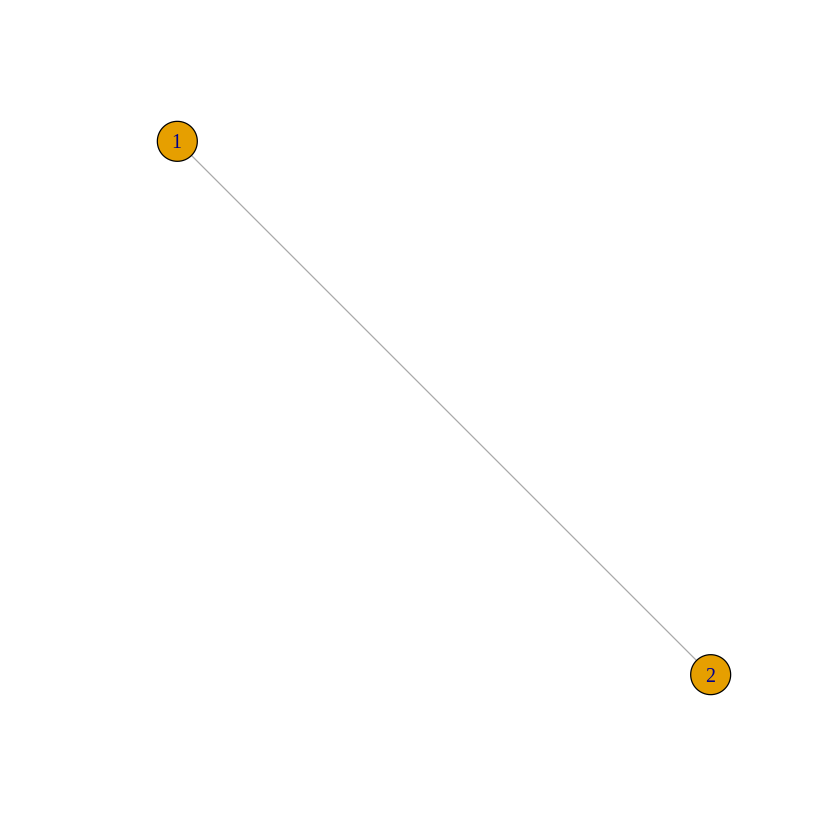

[1] "E(T) theoretical = 1.08697066666667e-07"
[1] "E(T) simulated = 1.07135254351838e-07"


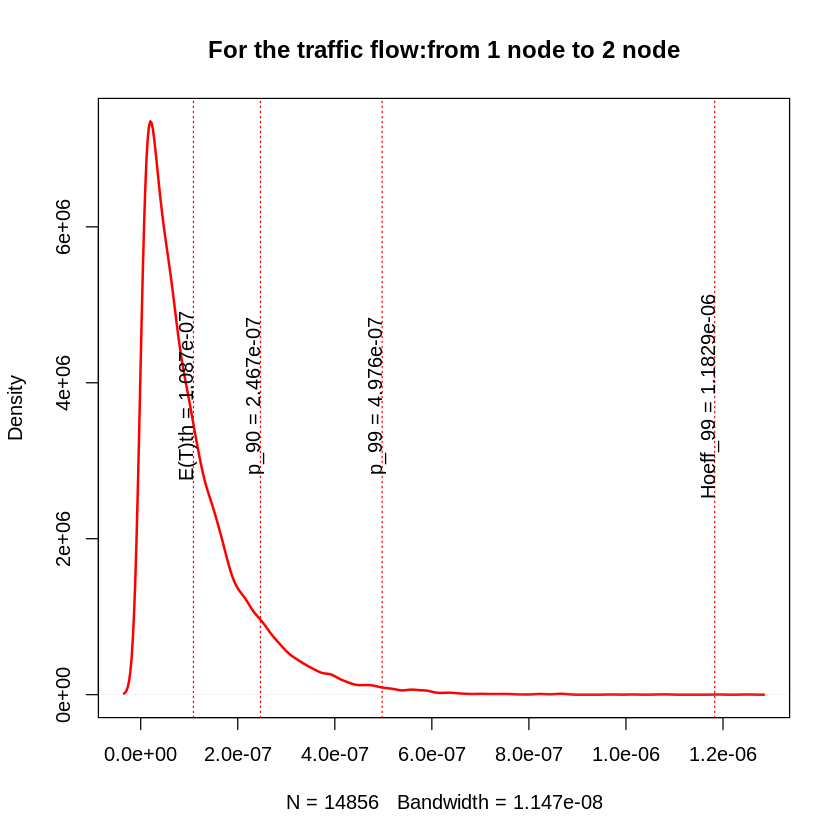

In [12]:
c(delay_th_mm1_L025, traffic_mm1_L025) := mm1_simulation(PS_size, PS_weights, Capacity_Gbps, Loads = 0.25, packets_number)


## Calculation of the lower and upper CI for each number of samples

In [13]:
resample_sizes <- c(5:30,(15:30)*2, (20:100)*3, (30:100)*10, (50:225)*20)

In [14]:
CI_calc_mm1 <- function(traffic_mm1, delay_th_mm1, resample_sizes, p, alpha = 0.01){
  # Perform bootstrap resampling with varying number of samples
  confidence_intervals <- matrix(NA, nrow = length(resample_sizes), ncol = 7)

  for (i in 1:length(resample_sizes)) {
    data <- sample(traffic_mm1, size=resample_sizes[i], replace=F) #takes the random samples from list os all arrivals without replacing
    # Perform bootstrap resampling
    boot_results <- boot(data, statistic = function(data, i) quantile(data[i], probs = p), R = 500)

    # Calculate confidence intervals
    boot_ci_output <- boot.ci(boot_results, conf = 1 - (alpha*2), type = "norm", index = 1)$normal
    value <- quantile(data, probs = p)

    lower_ci <- boot_ci_output[[2]]
    upper_ci <- boot_ci_output[[3]]
    confidence_intervals[i,1] <- boot_ci_output[[2]] # lower ci
    confidence_intervals[i,2] <- boot_ci_output[[3]] # upper ci
    confidence_intervals[i,3] <- quantile(data, probs = p) # quantile of the list
    confidence_intervals[i,4] <- delay_th_mm1*ln(1/(1 - p)) # theoretical Percentile
    confidence_intervals[i,5] <- resample_sizes[i] # list of packets size
    error_lower <- (1 - lower_ci/value)*100
    error_upper <- (upper_ci/value - 1)*100
    confidence_intervals[i,6] <- error_lower
    confidence_intervals[i,7] <-  error_upper

  }
  return(confidence_intervals)
}

In [15]:
confidence_intervals_L025_p99 <- CI_calc_mm1(traffic_mm1 =traffic_mm1_L025, delay_th_mm1 = delay_th_mm1_L025, resample_sizes = resample_sizes, p = 0.99)

In [16]:
confidence_intervals_L025_p90 <- CI_calc_mm1(traffic_mm1 =traffic_mm1_L025, delay_th_mm1 = delay_th_mm1_L025, resample_sizes = resample_sizes, p = 0.9)

In [17]:
confidence_intervals_L025_p75 <- CI_calc_mm1(traffic_mm1 =traffic_mm1_L025, delay_th_mm1 = delay_th_mm1_L025, resample_sizes = resample_sizes, p = 0.75)

##MM1 plot the results

###Plot of the execution times with different Number of Samples

In [18]:
CI_plot_func_mm1 <- function(confidence_intervals,p,alpha = 0.05, Traffic, ylim_max = 0.225, xlim_min = 80, Loads, error_CI = 10){
  plot_data <- data.frame(resamples = confidence_intervals[,5],
                          lower_ci = confidence_intervals[, 1]*1000000,
                          upper_ci = confidence_intervals[, 2]*1000000,
                          mean_q = confidence_intervals[, 3]*1000000,
                          mean_q_theoretical = confidence_intervals[, 4]*1000000,
                          #error_upper = confidence_intervals[,7]
                          error_upper = zoo::rollmean(confidence_intervals[,7], k = 10, fill = NA) )

  max_coef_sec_yaxis <- 100/ylim_max
  data_omit <- na.omit(plot_data)
  opt_samples <- ifelse(is.na(data_omit$resamples[data_omit$error_upper<error_CI][1]), 10000,data_omit$resamples[data_omit$error_upper<error_CI][1])
  # Create the plot
  plot <- ggplot(data_omit, aes(x = resamples)) +
    #geom_line(aes(y = lower_ci , color = "Queuing & transm delay lower CI"), size = 1) +
    geom_line(aes(y = upper_ci , color = "Upper CI, us"), size = 0.7) +
    geom_line(aes(y = mean_q , color = paste0("Delay sim p", p*100, ", us")), size = 0.7) +
    geom_line(aes(y = mean_q_theoretical , color = paste0("Delay theor p", p*100, ", us")), linetype = 2, size = 1) +
    #geom_line(aes(y =  error_lower/max_coef_sec_yaxis, color = "error lower CI, %"), linetype = 1, size = 0.7) +
    geom_line(aes(y =  error_upper/max_coef_sec_yaxis, color = "Error upper CI, %"), linetype = 1, size = 0.7) +
    geom_vline(aes(xintercept = opt_samples), color = "red", linetype = 4, size = 1) +
    geom_text(x = 3900, y = plot_data$mean_q_theoretical[1] - (ylim_max/40), label = paste("E(T)theor =", round(plot_data$mean_q_theoretical[1], digits = 3)), colour = "red", size = 5) +
    geom_text(x = opt_samples-80, y = ylim_max/2.5, label = paste("opt samples =", opt_samples, " for CI +", error_CI, "%"), colour = "black", angle = 90, size = 5) +

    scale_y_continuous(name = "Queuing and transm delay, us",
                       sec.axis = sec_axis(~.*max_coef_sec_yaxis, name = "error, %"), limits = c(0,ylim_max)) +
    xlim(c(min(confidence_intervals[,5]),4500)) +
    labs(
      #title = paste("Estimating Sufficient Number of Samples", "of quantile P =", p, ", \n confidence level alpha =", alpha, ",\n  Traffic =", Traffic, "p/s, Load =", Loads),
      x = "Number of Samples",
      y = "Queuing & transm delay, ms",
      color = "") +
    scale_color_manual(values = c("gray40","red", "blue","gray60")) +
    theme(axis.title.y.left = element_text(color = "gray20"),
          axis.title.y.right = element_text(color = "blue"), legend.position = c(0.8, 0.8))
  print(paste("Upper CI in %", ifelse(is.na(data_omit$error_upper[data_omit$error_upper<error_CI][1]), NA ,data_omit$error_upper[data_omit$error_upper<error_CI][1])))
  print(paste("Upper CI", ifelse(is.na(data_omit$upper_ci[data_omit$error_upper<error_CI][1]), NA ,data_omit$upper_ci[data_omit$error_upper<error_CI][1]) ))
  print(paste("Quantile value p", ifelse(is.na(data_omit$mean_q[data_omit$error_upper<error_CI][1]), NA ,data_omit$mean_q[data_omit$error_upper<error_CI][1]) ))
  print(paste("Optimal number of samples =",ifelse(is.na(data_omit$resamples[data_omit$error_upper<error_CI][1]), NA ,data_omit$resamples[data_omit$error_upper<error_CI][1]) ))
  print(paste("minimum accuracy % =", min(data_omit$error_upper) ))

  # Display the plot
  plot
  return(plot)
}


###99-th percentile

[1] "Upper CI in % 9.77645122318658"
[1] "Upper CI 0.517119914622641"
[1] "Quantile value p 0.477577889979994"
[1] "Optimal number of samples = 2460"
[1] "minimum accuracy % = 7.01648322470048"


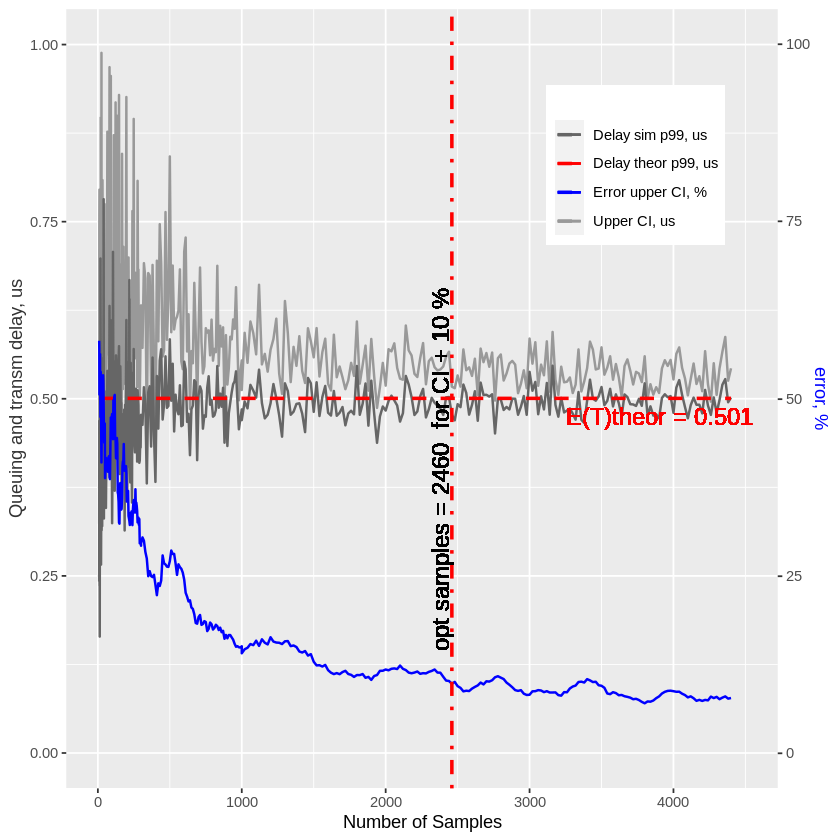

In [19]:
CI_plot_func_mm1(confidence_intervals_L025_p99, ylim_max = 1, p = 0.99, Loads = 0.25,error_CI = 10)

###90-th percentile

[1] "Upper CI in % 9.875834570653"
[1] "Upper CI 0.276329710198854"
[1] "Quantile value p 0.249648120794789"
[1] "Optimal number of samples = 940"
[1] "minimum accuracy % = 4.29646375954169"


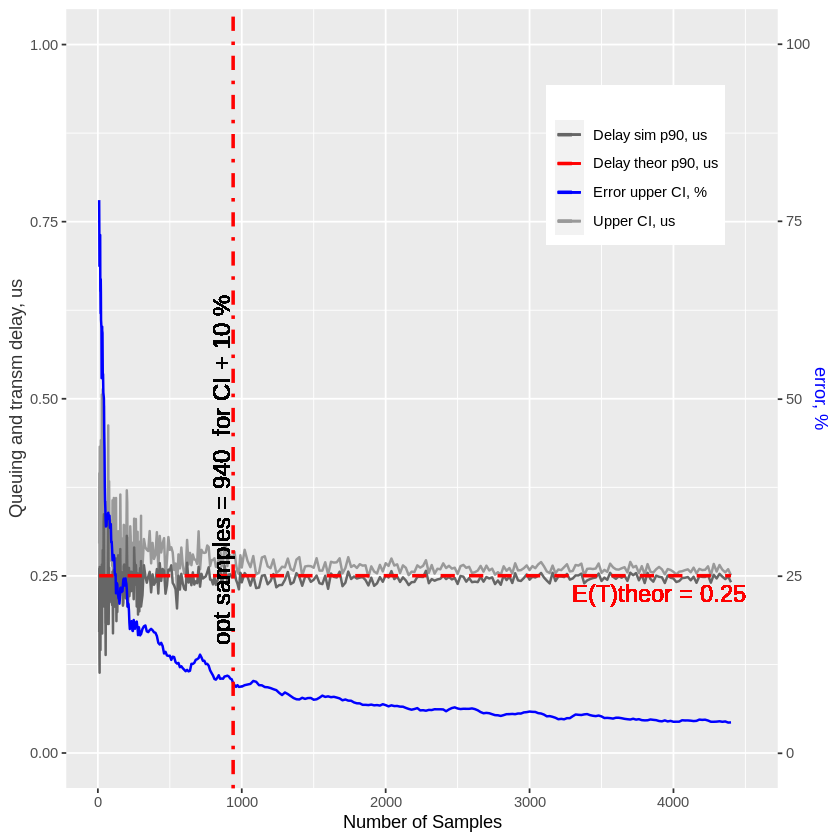

In [20]:
CI_plot_func_mm1(confidence_intervals_L025_p90, ylim_max = 1, p = 0.9, Loads = 0.25,error_CI = 10)


###75-th percentile

[1] "Upper CI in % 9.89827775416941"
[1] "Upper CI 0.159481339146632"
[1] "Quantile value p 0.148047194517065"
[1] "Optimal number of samples = 790"
[1] "minimum accuracy % = 3.71708499419595"


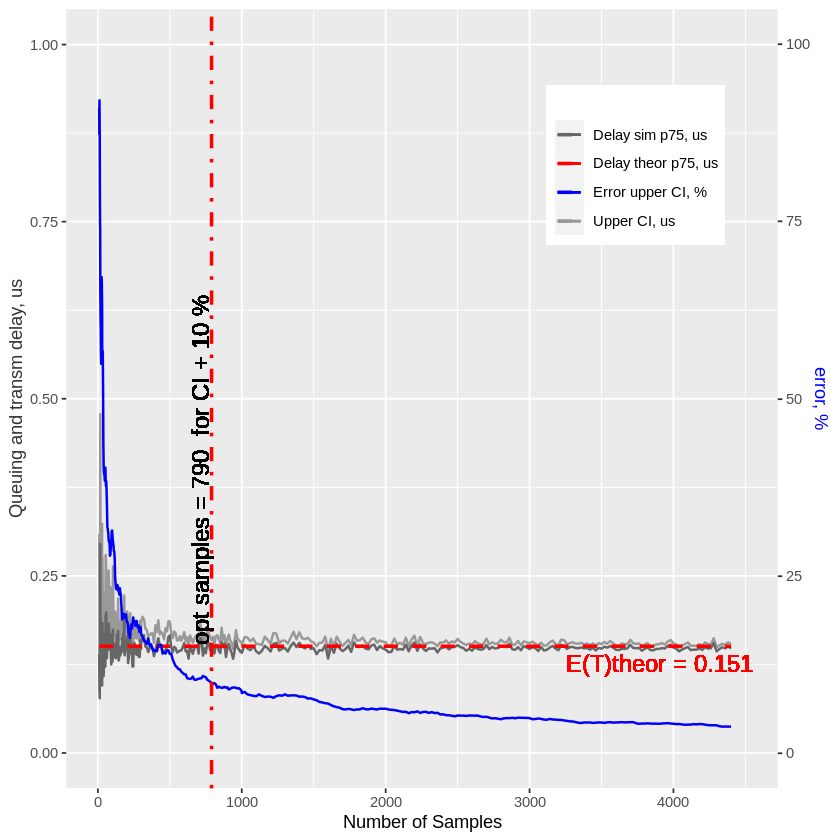

In [21]:
CI_plot_func_mm1(confidence_intervals_L025_p75, ylim_max = 1, p = 0.75, Loads = 0.25,error_CI = 10)


#GI/GI/1

In [39]:
CI_plot_func_gg1 <- function(confidence_intervals,p,alpha = 0.05, Traffic, ylim_max = 0.225, xlim_min = 80, Loads, error_CI = 10){
  plot_data <- data.frame(resamples = confidence_intervals[,5],
                          lower_ci = confidence_intervals[, 1]*1000000,
                          upper_ci = confidence_intervals[, 2]*1000000,
                          mean_q = confidence_intervals[, 3]*1000000,
                          mean_q_theoretical = confidence_intervals[, 4]*1000000,
                          #error_upper = confidence_intervals[,7]
                          error_upper = zoo::rollmean(confidence_intervals[,7], k = 10, fill = NA) )

  max_coef_sec_yaxis <- 100/ylim_max
  data_omit <- na.omit(plot_data)
  opt_samples <- ifelse(is.na(data_omit$resamples[data_omit$error_upper<error_CI][1]), 10000,data_omit$resamples[data_omit$error_upper<error_CI][1])
  # Create the plot
  plot <- ggplot(data_omit, aes(x = resamples)) +
    geom_line(aes(y = upper_ci , color = "Upper CI, us"), size = 0.7) +
    geom_line(aes(y = mean_q , color = paste0("Delay sim p", p*100, ", us")), size = 0.7) +
    geom_line(aes(y =  error_upper/max_coef_sec_yaxis, color = "Error upper CI, %"), linetype = 1, size = 0.7) +
    geom_vline(aes(xintercept = opt_samples), color = "red", linetype = 4, size = 1) +
    geom_text(x = opt_samples-80, y = ylim_max/2.5, label = paste("opt samples =", opt_samples, " for CI +", error_CI, "%"), colour = "black", angle = 90, size = 5) +

    scale_y_continuous(name = "Queuing and transm delay, us",
                       sec.axis = sec_axis(~.*max_coef_sec_yaxis, name = "error, %"), limits = c(0,ylim_max)) +
    xlim(c(min(confidence_intervals[,5]),4500)) +
    labs(
      #title = paste("Estimating Sufficient Number of Samples", "of quantile P =", p, ", \n confidence level alpha =", alpha, ",\n  Traffic =", Traffic, "p/s, Load =", Loads),
      x = "Number of Samples",
      y = "Queuing & transm delay, ms",
      color = "") +
    scale_color_manual(values = c("gray40", "blue","gray60")) +
    theme(axis.title.y.left = element_text(color = "gray20"),
          axis.title.y.right = element_text(color = "blue"), legend.position = c(0.8, 0.8))
  print(paste("Upper CI in %", ifelse(is.na(data_omit$error_upper[data_omit$error_upper<error_CI][1]), NA ,data_omit$error_upper[data_omit$error_upper<error_CI][1])))
  print(paste("Upper CI", ifelse(is.na(data_omit$upper_ci[data_omit$error_upper<error_CI][1]), NA ,data_omit$upper_ci[data_omit$error_upper<error_CI][1]) ))
  print(paste("Quantile value p", ifelse(is.na(data_omit$mean_q[data_omit$error_upper<error_CI][1]), NA ,data_omit$mean_q[data_omit$error_upper<error_CI][1]) ))
  print(paste("Optimal number of samples =",ifelse(is.na(data_omit$resamples[data_omit$error_upper<error_CI][1]), NA ,data_omit$resamples[data_omit$error_upper<error_CI][1]) ))
  print(paste("minimum accuracy % =", min(data_omit$error_upper) ))

  # Display the plot
  plot
  return(plot)
}


In [59]:
CI_calc_gg1 <- function(traffic_gg1, resample_sizes, p, alpha = 0.01){
  # Perform bootstrap resampling with varying number of samples
  confidence_intervals <- matrix(NA, nrow = length(resample_sizes), ncol = 7)

  for (i in 1:length(resample_sizes)) {
    data <- sample(traffic_gg1, size=resample_sizes[i], replace=F) #takes the random samples from list os all arrivals without replacing
    # Perform bootstrap resampling
    boot_results <- boot(data, statistic = function(data, i) quantile(data[i], probs = p), R = 1000)

    # Calculate confidence intervals
    boot_ci_output <- boot.ci(boot_results, conf = 1 - (alpha*2), type = "norm", index = 1)$normal
    value <- quantile(data, probs = p)

    lower_ci <- boot_ci_output[[2]]
    upper_ci <- boot_ci_output[[3]]
    confidence_intervals[i,1] <- boot_ci_output[[2]] # lower ci
    confidence_intervals[i,2] <- boot_ci_output[[3]] # upper ci
    confidence_intervals[i,3] <- quantile(data, probs = p) # quantile of the list
    confidence_intervals[i,4] <- quantile(traffic_gg1, p) # theoretical Percentile
    confidence_intervals[i,5] <- resample_sizes[i] # list of packets size
    error_lower <- (1 - lower_ci/value)*100
    error_upper <- (upper_ci/value - 1)*100
    confidence_intervals[i,6] <- error_lower
    confidence_intervals[i,7] <-  error_upper

  }
  return(confidence_intervals)
}

##Simulation

###function for generating bursting

 U(1;n)

In [25]:
 ####################for interarrival times
generator_burst <- function(n, lambda_burst)
{
  lambda_burst <- force(lambda_burst)
  first_packet <- c(rexp(1,lambda_burst))
  burst_packets <- rep(0, sample((1-1):(n-1),1,TRUE))
  return(c(first_packet, burst_packets))
}

In [61]:
simulation_simmer_gg1 <- function(PS_size, PS_weights, Capacity_Gbps, n_bursting, Loads, packets_number = 1000) {
  N = sum(PS_size*PS_weights)
  g <- make_graph(edges = c(1,2), n=2, directed = FALSE)
  E(g)$Capacity_Gbps <- Capacity_Gbps
  E(g)$Load <- Loads
  E(g)$Capacity_ps <- Capacity_Gbps*10^10/(8*N)
  E(g)$Ni <- E(g)$Load/(1-E(g)$Load) # average number of packets in each system
  E(g)$Capacity_Bps <- E(g)$Capacity_ps*N*8

  n_bursting = force(n_bursting)
  c(E(g)$Queue_Delay, E(g)$Traffic, E(g)$Traffic_burst) := calc_queue_delay_burst(C = E(g)$Capacity_Bps, L = E(g)$Load, n = n_bursting, PS_size, PS_weights)
  print(paste("Traffic_ps", E(g)$Traffic))
  ##################simmer
  set.seed(42)

  env <- simmer("SuperDuperSim") #creating the simmer environment
  env <- simmer_resources(g, env) # add resources for all nodes of igraph (func is in the file simmer_fictions)
  lambda_simmer <- E(g)[1]$Traffic_burst
  print(lambda_simmer)
  print(paste("timeout",(sample(PS_size,size = 1,replace = T, prob = PS_weights)*8)/E(g)[1]$Capacity_Bps))

  ########################################version without dataframe
  traffic_1_2_ <- trajectory()%>%
    seize("node_1") %>%
    timeout(function() (sample(PS_size,size = 1,replace = T, prob = PS_weights)*8)/E(g)[1]$Capacity_Bps) %>%
    release("node_1")


  env %>%
    add_generator("traffic_1_2_", traffic_1_2_, function() generator_burst(n_bursting, lambda_simmer))

  env %>%
     reset() %>%
     run(until = packets_number/min(E(g)$Traffic_burst), progress=progress::progress_bar$new()$update)


  traffic_traj_name <- "traffic_1_2_"
  #########################delay results processing for traffic flow
  all_arrivals_res <- data.frame(env %>%
                                   get_mon_arrivals(per_resource = FALSE) %>%
                                   transform(waiting_time_in_queue = round(end_time - start_time - activity_time)) %>%
                                   transform(spending_time = end_time - start_time))
  digits = 10

  traffic <- all_arrivals_res$spending_time
  print(paste("e2e sim delay:", mean(traffic)))


  return(traffic)


}



In [28]:
Loads = 0.25

### n = 20

In [63]:
c(traffic_gg1_n20) := simulation_simmer_gg1(PS_size, PS_weights, Capacity_Gbps, n_bursting = 20, Loads, packets_number)

[1] "Traffic_ps 3066626.75963043"
[1] 292059.7
[1] "timeout 4.246e-07"
[1] "e2e sim delay: 7.98343771603432e-07"


### n = 100

In [64]:
c(traffic_gg1_n100) := simulation_simmer_gg1(PS_size, PS_weights, Capacity_Gbps, n_bursting = 100, Loads, packets_number)

[1] "Traffic_ps 3066626.75963043"
[1] 60725.28
[1] "timeout 4.246e-07"
[1] "e2e sim delay: 3.71611125018359e-06"


## Calculation of the lower and upper CI for each number of samples

###99-th percentile

In [70]:
confidence_intervals_L025_p99_gg1_n20 <- CI_calc_gg1(traffic_gg1 = traffic_gg1_n20, resample_sizes = resample_sizes, p = 0.99)
confidence_intervals_L025_p99_gg1_n100 <- CI_calc_gg1(traffic_gg1 = traffic_gg1_n100, resample_sizes = resample_sizes, p = 0.99)

[1] "Upper CI in % 9.99556877396776"
[1] "Upper CI 3.14574751525572"
[1] "Quantile value p 2.8489962186138"
[1] "Optimal number of samples = 2120"
[1] "minimum accuracy % = 6.38720302490837"


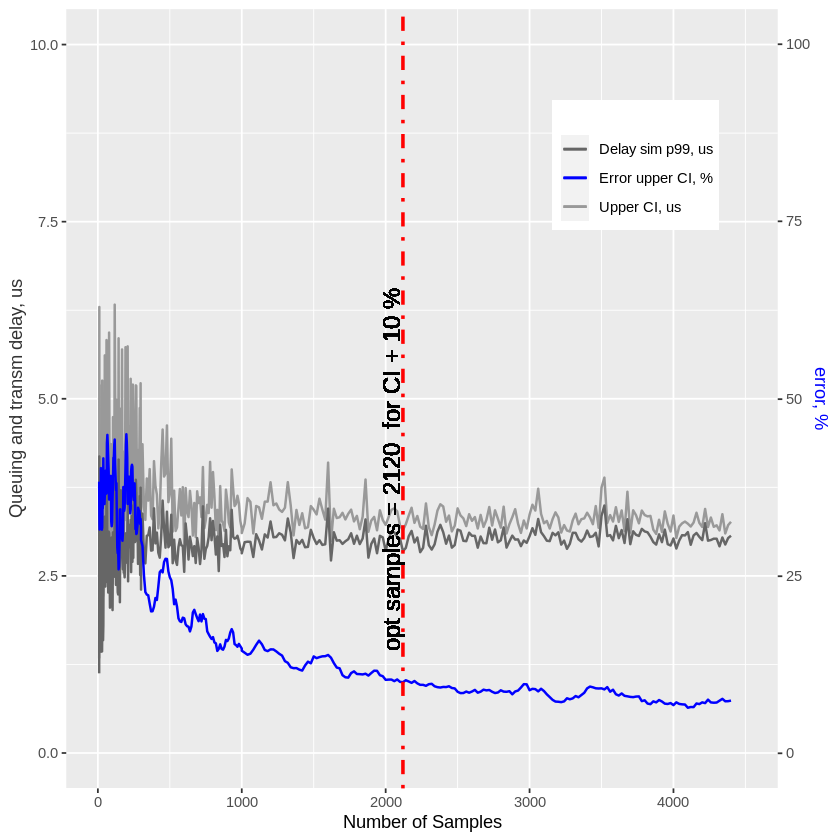

In [71]:
CI_plot_func_gg1(confidence_intervals_L025_p99_gg1_n20, ylim_max = 10, p = 0.99, Loads = 0.25,error_CI = 10)

[1] "Upper CI in % 9.85077003170644"
[1] "Upper CI 14.6013680325822"
[1] "Quantile value p 13.3362297142195"
[1] "Optimal number of samples = 2080"
[1] "minimum accuracy % = 6.07968165693052"


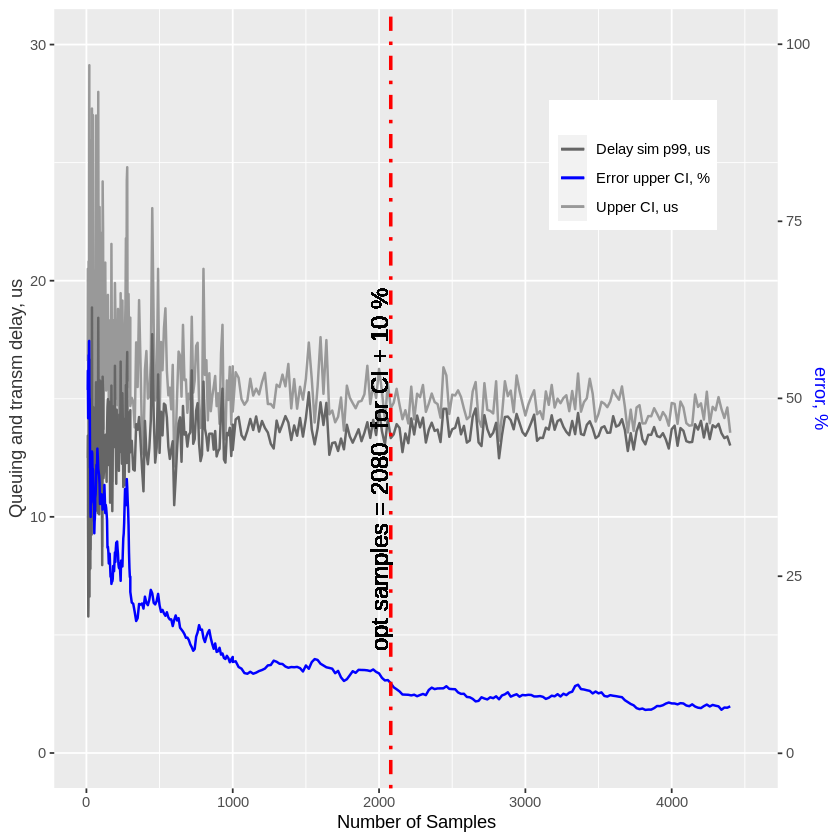

In [72]:
CI_plot_func_gg1(confidence_intervals_L025_p99_gg1_n100, ylim_max = 30, p = 0.99, Loads = 0.25,error_CI = 10)

###90-th percentile

In [48]:
confidence_intervals_L025_p90_gg1_n20 <- CI_calc_gg1(traffic_gg1 = traffic_gg1_n20, resample_sizes = resample_sizes, p = 0.9)
confidence_intervals_L025_p90_gg1_n100 <- CI_calc_gg1(traffic_gg1 = traffic_gg1_n100, resample_sizes = resample_sizes, p = 0.9)

[1] "Upper CI in % 9.9177511077315"
[1] "Upper CI 2.17430442442173"
[1] "Quantile value p 1.85656817621241"
[1] "Optimal number of samples = 560"
[1] "minimum accuracy % = 3.52164815979169"


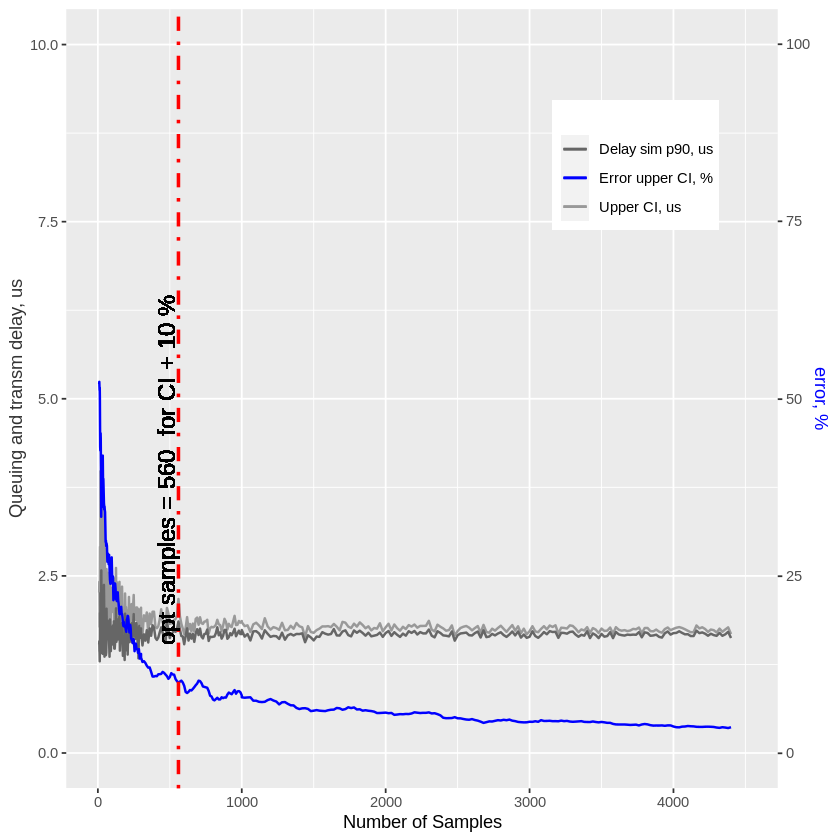

In [50]:
CI_plot_func_gg1(confidence_intervals_L025_p90_gg1_n20, ylim_max = 10, p = 0.9, Loads = 0.25,error_CI = 10)


[1] "Upper CI in % 9.97840747747265"
[1] "Upper CI 8.60527012860101"
[1] "Quantile value p 7.57087538638106"
[1] "Optimal number of samples = 460"
[1] "minimum accuracy % = 3.36054795280674"


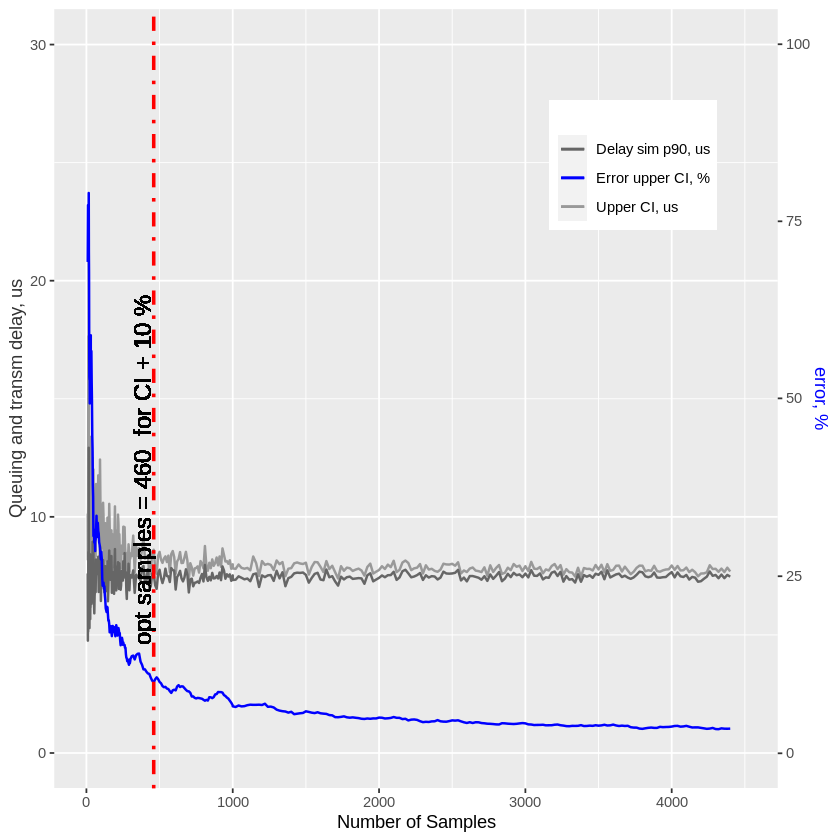

In [51]:
CI_plot_func_gg1(confidence_intervals_L025_p90_gg1_n100, ylim_max = 30, p = 0.9, Loads = 0.25,error_CI = 10)


###75-th percentile

In [66]:
confidence_intervals_L025_p75_gg1_n20 <- CI_calc_gg1(traffic_gg1 = traffic_gg1_n20,  resample_sizes = resample_sizes, p = 0.75)


In [67]:
confidence_intervals_L025_p75_gg1_n100 <- CI_calc_gg1(traffic_gg1 = traffic_gg1_n100,  resample_sizes = resample_sizes, p = 0.75)

[1] "Upper CI in % 9.97972717261164"
[1] "Upper CI 1.2196427757672"
[1] "Quantile value p 1.11360000000504"
[1] "Optimal number of samples = 500"
[1] "minimum accuracy % = 3.31701985459848"


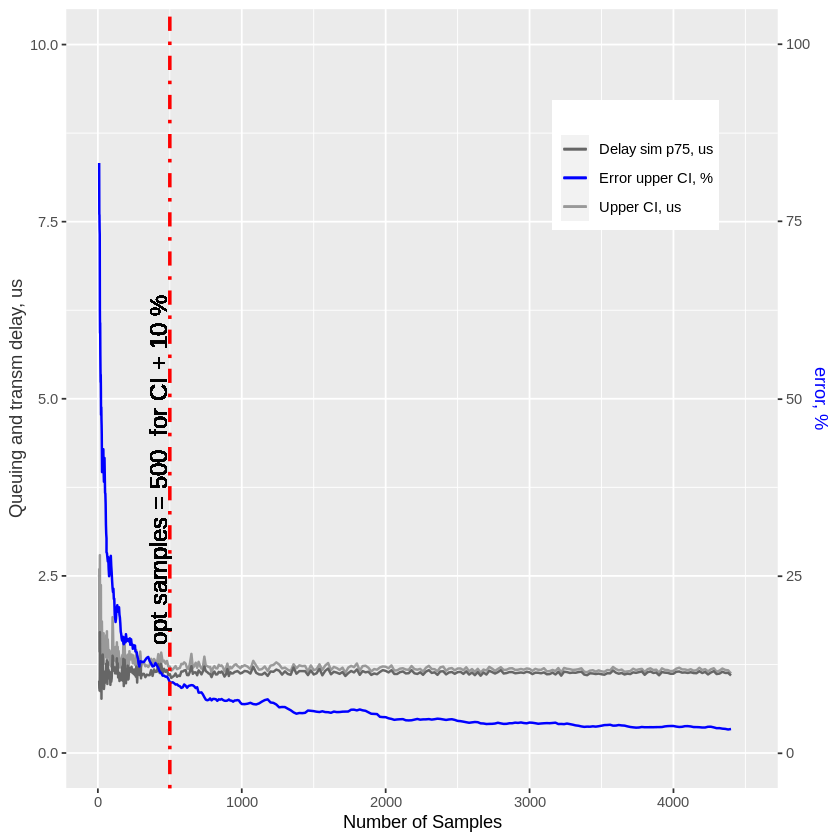

In [68]:
CI_plot_func_gg1(confidence_intervals_L025_p75_gg1_n20, ylim_max = 10, p = 0.75, Loads = 0.25,error_CI = 10)


[1] "Upper CI in % 9.8045753230065"
[1] "Upper CI 5.66367057948208"
[1] "Quantile value p 5.11744555330845"
[1] "Optimal number of samples = 420"
[1] "minimum accuracy % = 2.92950649352644"


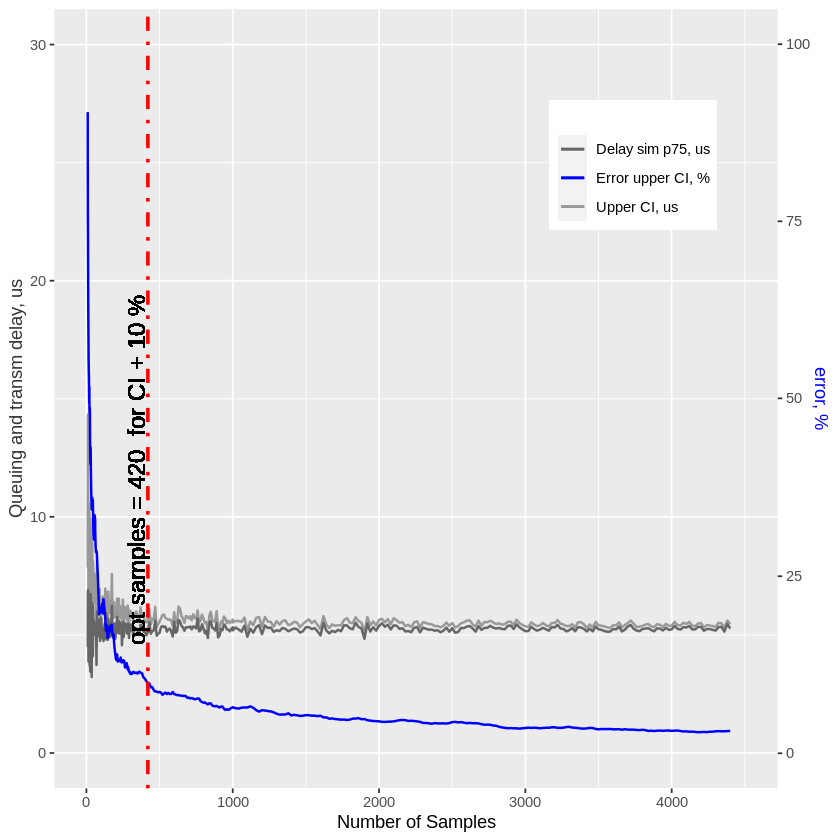

In [69]:
CI_plot_func_gg1(confidence_intervals_L025_p75_gg1_n100, ylim_max = 30, p = 0.75, Loads = 0.25,error_CI = 10)
